In [ ]:
# Armaan Kapoor - https://github.com/ak2k2
# IMC Prosperity 2024 - Team Quant NYC
# Members: Armaan Kapoor, Harshil Cherukuri and Shyam Parikh

In [76]:
import re
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.stats import kurtosis, normaltest, skew

log_path = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/submissions/2024-04-20_04-47-05.log"

def read_file_sections(filepath):
    section_delimiters = ["Sandbox logs:", "Activities log:", "Trade History:"]
    current_section = None
    data = {key: [] for key in section_delimiters}

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()
            if line in section_delimiters:
                current_section = line
                continue
            if current_section:
                data[current_section].append(line)

    return data


def extract_trades(text):
    # Regex to find all blocks enclosed in curly braces
    trade_pattern = r"\{[^{}]*\}"
    # Regex to extract key-value pairs within curly braces
    kv_pattern = r"\"(\w+)\":\s*(\"[^\"]*\"|\d+)"

    trades = []
    matches = re.findall(trade_pattern, text)
    for match in matches:
        trade_data = {}
        for key, value in re.findall(kv_pattern, match):
            if value.startswith('"') and value.endswith('"'):
                value = value.strip('"')
            else:
                value = int(value)
            trade_data[key] = value
        trades.append(trade_data)
    return trades


sections = read_file_sections(log_path)
activities_data = "\n".join(sections["Activities log:"])
activities_df = pd.read_csv(StringIO(activities_data), delimiter=";")
trade_history_text = "\n".join(sections["Trade History:"])
trades = extract_trades(trade_history_text)
trade_history_df = pd.DataFrame(trades)

In [77]:
df = pd.read_csv("/Users/armaan/Desktop/imc-prosperity-quant-nyc/data_bottles/round-4-island-data-bottle/prices_round_4_day_3.csv", sep=";")

In [78]:
df = activities_df[["timestamp", "product", "mid_price", "profit_and_loss"]]

df = df.pivot_table(
    index="timestamp",
    columns="product",
    values=["mid_price", "profit_and_loss"],
    aggfunc="mean",
).reset_index()

df.columns = [
    f"{col[1].lower()}_{col[0]}" if col[1] else col[0] for col in df.columns
]

df = df[["timestamp", "coconut_mid_price", "coconut_coupon_mid_price"]]

In [79]:
def quantile_normalize(series):
    sorted_series = series.sort_values()
    norm = np.random.normal(
        loc=0, scale=1, size=len(series)
    )  # generate a normal distribution
    norm.sort()
    quantile_norm = series.copy().sort_values().reset_index(drop=True)
    quantile_norm.loc[sorted_series.index] = (
        norm  # assign normal values based on the rank
    )
    return quantile_norm


# Enriching Coconut Data With Options Stuff
---

the intrinsic value of coconut_coupon is 0 for the entire duration of live submission data

1 day = 10_000 ticks.
1 tick = 100 timestamps
1 day = 1,000,000 timestamps

In [86]:
from scipy.stats import norm
import statistics

df["coconut_return"] = df["coconut_mid_price"].pct_change()
annualized_historical_vol = df["coconut_return"].std() * np.sqrt(10000)

df["timestamps_till_expiration"] = 250_000_000 - df["timestamp"]

print(f"annualized_historical_vol: {annualized_historical_vol}")

df["days_to_expiration"] = df["timestamps_till_expiration"] / 1000000
df["years_to_expiration"] = df["days_to_expiration"] / 252


def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price for a European call option.
    S : Current price of the underlying
    K : Strike price of the option
    T : Time to expiration in years
    r : Risk-free rate
    sigma : Volatility of the underlying

    Parameters:
    - S (float): current price of the underlying asset
    - K (float): strike price of the option
    - T (float): time to expiration in years
    - r (float): annual risk-free interest rate
    - sigma (float): volatility of the underlying asset
    """
    # Create a normal distribution object for the standard normal
    N = statistics.NormalDist(mu=0, sigma=1)

    # Calculate d1 and d2 components of the Black-Scholes formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate the call price using the Black-Scholes formula
    call_price = S * N.cdf(d1) - K * np.exp(-r * T) * N.cdf(d2)
    return call_price


risk_free_rate = 0.0

df["bs_call_price"] = df.apply(
    lambda row: black_scholes_call(
        row["coconut_mid_price"],
        10000,  # Strike price
        row["days_to_expiration"],
        risk_free_rate,
        # row['rolling_annualized_volatility'],
        0.01011932923,
    ),
    axis=1,
)

annualized_historical_vol: 0.010353856154637369


---

# Updated method where we first dake the differnce in option and underlying (option premium) and then calc z

In [81]:
import pandas as pd


df["coconut_coupon_mid_price_qnorm"] = quantile_normalize(
    df["coconut_coupon_mid_price"]
)
df["bs_call_price_qnorm"] = quantile_normalize(df["bs_call_price"])

# Calculate the price difference
df["price_diff_qnorm"] = (
    df["coconut_coupon_mid_price_qnorm"] - df["bs_call_price_qnorm"]
)

# Calculate rolling statistics for the difference
df["diff_mean"] = df["price_diff_qnorm"].expanding().mean()
df["diff_std"] = df["price_diff_qnorm"].expanding().std()

# Calculate z-scores for the difference
df["price_diff_z_score"] = (df["price_diff_qnorm"] - df["diff_mean"]) / df["diff_std"]

# window_size = 10
# # Calculate moving average and moving standard deviation
# df['moving_avg'] = df['price_diff_qnorm'].rolling(window=window_size).mean()
# df['moving_std'] = df['price_diff_qnorm'].rolling(window=window_size).std()

# # Calculate upper and lower Bollinger Bands
# df["upper_band"] = df["moving_avg"] + (df["moving_std"] * 2)
# df["lower_band"] = df["moving_avg"] - (df["moving_std"] * 2)



# Optionally, drop rows with NaN values that result from rolling calculation
df = df.dropna()

In [85]:
df

,timestamp,coconut_mid_price,coconut_coupon_mid_price,coconut_return,timestamps_till_expiration,days_to_expiration,years_to_expiration,bs_call_price,coconut_coupon_mid_price_qnorm,bs_call_price_qnorm,price_diff_qnorm,diff_mean,diff_std,price_diff_z_score
1,100,9990.0,620.5,-0.000100,249999900,249.9999,0.992063,632.323492,2.586080,2.444891,0.141189,-0.032255,0.245287,0.707107
2,200,9990.5,620.5,0.000050,249999800,249.9998,0.992063,632.588093,2.547019,2.614300,-0.067281,-0.043930,0.174619,-0.133723
3,300,9991.5,621.5,0.000100,249999700,249.9997,0.992062,633.117608,2.747986,2.851742,-0.103756,-0.058887,0.145680,-0.308001
4,400,9990.0,621.5,-0.000150,249999600,249.9996,0.992062,632.323110,2.683509,2.391355,0.292154,0.011321,0.201402,1.394387
5,500,9988.5,620.5,-0.000150,249999500,249.9995,0.992062,631.529172,2.515095,2.378551,0.136543,0.032192,0.187253,0.557274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,99500,9961.0,597.5,0.000050,249900500,249.9005,0.991669,616.949652,-0.280465,0.228713,-0.509178,-0.037004,0.643836,-0.733376
996,99600,9960.5,596.5,-0.000050,249900400,249.9004,0.991668,616.688480,-0.446034,0.191571,-0.637605,-0.037606,0.643794,-0.931974
997,99700,9962.5,595.5,0.000201,249900300,249.9003,0.991668,617.732908,-0.539551,0.331808,-0.871359,-0.038442,0.644012,-1.293326
998,99800,9963.5,597.5,0.000100,249900200,249.9002,0.991667,618.255434,-0.350024,0.378763,-0.728787,-0.039133,0.644060,-1.070793


In [83]:
SIGNAL_COL = "price_diff_z_score"
threshold = 2.4
ASSET = "coconut_coupon_mid_price"

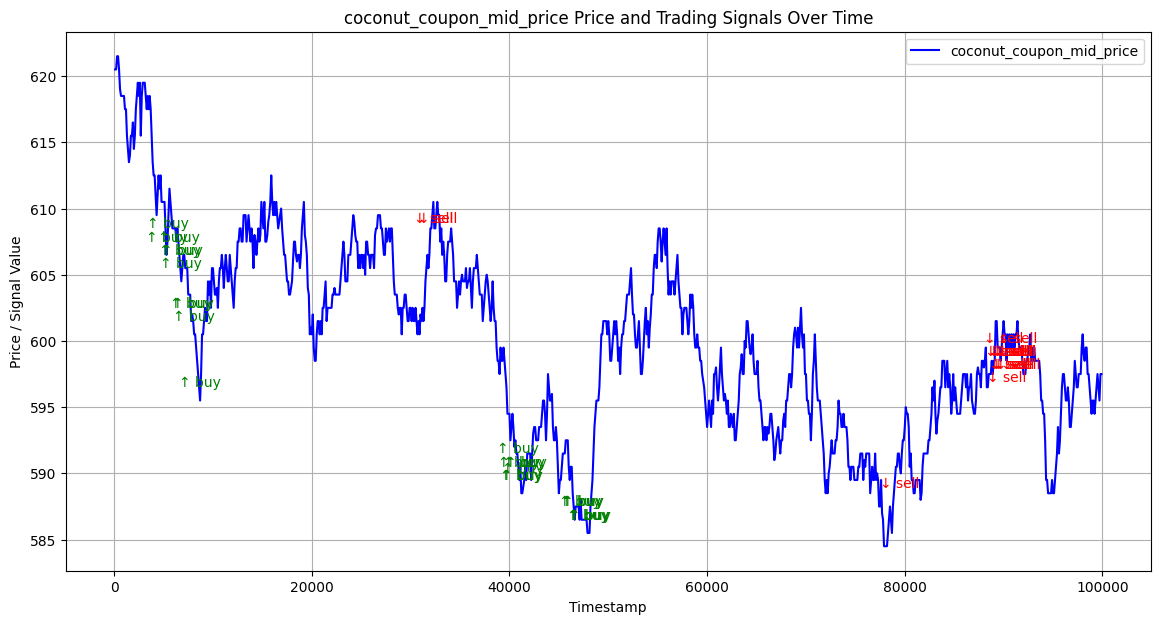

In [84]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 7))

plt.plot(
    df["timestamp"],
    df[ASSET],
    label=ASSET,
    color="blue",
)
# Adding buy and sell signals
for i in df.index:
    if df.loc[i, SIGNAL_COL] > threshold:
        plt.annotate(
            "↓ sell",
            (df.loc[i, "timestamp"], df.loc[i, ASSET]),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
            color="red",
        )
    elif df.loc[i, SIGNAL_COL] < -threshold:
        plt.annotate(
            "↑ buy",
            (df.loc[i, "timestamp"], df.loc[i, ASSET]),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            color="green",
        )

plt.title(f"{ASSET} Price and Trading Signals Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Price / Signal Value")
plt.legend()
plt.grid(True)

plt.show()

<AxesSubplot: >

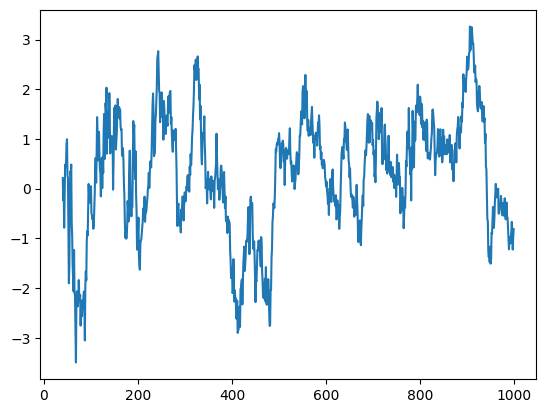

In [52]:
df["price_diff_z_score"].plot()